### Phase estimation

This example will estimate the phase of an Unitary operation, following the algorithm and example proposed on [Prokopenya, A.N.:Simulation of a Quantum Algorithm
for Phase Estimation](https://www.researchgate.net/profile/Alexander_Prokopenya/publication/273676670_Simulation_of_a_Quantum_Algorithm_for_Phase_Estimation/links/551ed8240cf2a2d9e1402ef9.pdf)

In [1]:
import projectq
from projectq.cengines import MainEngine
from projectq.ops import H,X,BasicGate,Measure,QFT,get_inverse,All
from projectq.meta import Control
import numpy as np
import math
import cmath


Using the BasicGate class, we create a general class that implements any U operation generated by a unitary matrix

In [2]:
class UGate(BasicGate):
    def __init__(self,matrix):
        BasicGate.__init__(self)
        self._matrix=np.matrix(matrix)
    @property
    def matrix(self):
        return self._matrix



Now we create the unitary operation for applying a phase to a single qubit:

$$U=
\begin{bmatrix} 
1& 0   \\
 0 & e^{i2\pi\phi} 
\end{bmatrix}
$$

In [3]:
phi=2./3.
M=[[1.,0.],[0,cmath.exp(1j*2.*math.pi*phi)]]
U=UGate(np.array(M,np.complex128))


 Now, construct the circuit for the phase estimation for state |1> [circuit](../quirk.html#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%2C%22H%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C1%2C1%2C1%2C1%2C%22~qbpi%22%5D%2C%5B1%2C%22%E2%80%A2%22%2C1%2C1%2C1%2C%22~45a8%22%5D%2C%5B1%2C1%2C%22%E2%80%A2%22%2C1%2C1%2C%22~b8l%22%5D%2C%5B1%2C1%2C1%2C%22%E2%80%A2%22%2C1%2C%22~7ree%22%5D%2C%5B1%2C1%2C1%2C1%2C%22%E2%80%A2%22%2C%22~mquj%22%5D%2C%5B%22QFT%E2%80%A05%22%5D%5D%2C%22gates%22%3A%5B%7B%22id%22%3A%22~qbpi%22%2C%22name%22%3A%22U1%22%2C%22matrix%22%3A%22%7B%7B1%2C0%7D%2C%7B0%2C-%C2%BD-%E2%88%9A%C2%BEi%7D%7D%22%7D%2C%7B%22id%22%3A%22~45a8%22%2C%22name%22%3A%22U2%22%2C%22matrix%22%3A%22%7B%7B1%2C0%7D%2C%7B0%2C-%C2%BD%2B%E2%88%9A%C2%BEi%7D%7D%22%7D%2C%7B%22id%22%3A%22~b8l%22%2C%22name%22%3A%22U4%22%2C%22matrix%22%3A%22%7B%7B1%2C0%7D%2C%7B0%2C-%C2%BD-%E2%88%9A%C2%BEi%7D%7D%22%7D%2C%7B%22id%22%3A%22~7ree%22%2C%22name%22%3A%22U8%22%2C%22matrix%22%3A%22%7B%7B1%2C0%7D%2C%7B0%2C-%C2%BD%2B%E2%88%9A%C2%BEi%7D%7D%22%7D%2C%7B%22id%22%3A%22~mquj%22%2C%22name%22%3A%22U16%22%2C%22matrix%22%3A%22%7B%7B1%2C0%7D%2C%7B0%2C-%C2%BD-%E2%88%9A%C2%BEi%7D%7D%22%7D%5D%7D)

In [4]:
def phase_estimation(U,accuracy):
    eng=MainEngine()
    rows, cols = U.matrix.shape
    m = int(math.log2(rows))
    output_qubits = eng.allocate_qureg(accuracy)
    U_qubits = eng.allocate_qureg(m)    
    X|U_qubits
    # Hadamard initialization of the output qubits
    All(H) | output_qubits
    for i,q in enumerate(output_qubits):
        if i > 0:
            U = UGate(np.dot(U.matrix, U.matrix))
            
        with Control(eng,q):
            U | U_qubits
    #
    # And apply the inverse QFT
    #
    get_inverse(QFT) | output_qubits
    #
    # Measure
    #
    
    All(Measure) | output_qubits
    All(Measure) | U_qubits
    eng.flush()
    output=[int(q) for q in output_qubits]
    ancilla=[int(q) for q in U_qubits]
    
    del output_qubits
    del U_qubits
    del eng
    #
    # And convert to integer the result
    #
    bits=0
    for (k,i) in enumerate(output):

        bits=bits+i*2.**k
        
    return bits


We will calculate the fase with an accuracy of $$\frac{1}{2^5}$$

Because this is a probabilistic algorithm, we have to repeat the experiment several times. In this case, 100

In [5]:
accuracy=5
experiments=100
out=[]
for i in range(experiments):
    out.append(phase_estimation(U,accuracy=accuracy))



Plot the probabilities for each integer

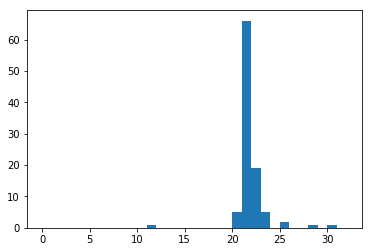

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)))

And calculate the margins

In [7]:
lox=x[1][np.argmax(x[0])]
x[0][np.argmax(x[0])]=0.
hix=round(x[1][np.argmax(x[0])])
print("Phi: %f < Angle(%f) < %f"%(float(lox)/float(2**accuracy),phi,float(hix)/float(2**accuracy)))

Phi: 0.656250 < Angle(0.666667) < 0.687500
